# Weather Forecasting Project - ESIEE PARIS - E4 AIC 
### By Valentin MAIA, Téo MARTIN, Paul PHUONG, Cédric SUN and William TRAVERS.
### Under the monitoring of Charif EL JAZOULI


Our group has been diligently working on a weather prediction project utilizing data from the Hybrid Energy Forecasting and Trading Competition. Our primary objective was to forecast the 'solar_MW' feature, leveraging a model trained on data spanning from 2020 to 2023. This project, undertaken as part of our academic curriculum, has provided us with invaluable opportunities to enhance our skills in data science and data visualization. Through rigorous analysis and modeling, we aimed to utilize historical weather patterns to develop a predictive model. 

## Librairies

In order to run this notebook several libraries will be used. 

Download the several librairies by running in your terminal "pip install -r requirements.txt"

In [1]:
# For loading the dataset
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

# For the preprocessing
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

# For the models
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm

# For the score's predictions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# For plotting the dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Pickle file
import pickle

# For the dashboard
from dash import Dash, html, dcc, Input, Output, callback
import plotly.graph_objects as go
    

# Data Cleaning



Firstly, we will create a dataset with all the features from the different csv and nc files.
Here is the data from the Energy's csv file which compile data from 2020 to 2023.

In [2]:
dataRaw = pd.read_csv("Energy_Data_20200920_20231027.csv")
dataRaw

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20T00:00:00Z,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20T00:30:00Z,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17
2,2020-09-20T01:00:00Z,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
3,2020-09-20T01:30:00Z,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00
4,2020-09-20T02:00:00Z,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
...,...,...,...,...,...,...,...,...,...
54379,2023-10-27T21:30:00Z,NaN,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47
54380,2023-10-27T22:00:00Z,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
54381,2023-10-27T22:30:00Z,NaN,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31
54382,2023-10-27T23:00:00Z,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


Then, we load the nc file containing the Cloud Cover, Solar Downward Radiation and Temperature features from the same period.

In [3]:
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar

<xarray.Dataset>
Dimensions:                 (ref_datetime: 4467, valid_datetime: 93, point: 20)
Coordinates:
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * ref_datetime            (ref_datetime) datetime64[ns] 2020-09-20 ... 2023...
  * valid_datetime          (valid_datetime) int64 0 1 2 3 4 ... 111 114 117 120
Data variables:
    CloudCover              (ref_datetime, valid_datetime, point) float32 ...
    SolarDownwardRadiation  (ref_datetime, valid_datetime, point) float64 ...
    Temperature             (ref_datetime, valid_datetime, point) float32 ...

We retrieve the 3 features and merge it into a single dataframe.

In [4]:
dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_featuresInter = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd_solar_features = dwd_solar_featuresInter.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")
dwd_solar_features

,ref_datetime,valid_datetime,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.000000,0.681062,14.022113
...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,0.932845,0.652018,8.682965


Secondly, we load the interesting features related to the target feature Solar_MW from this nc file, RelativeHumidity, Temperature and TotalPrecipitation.

In [5]:
dwd_rain = xr.open_dataset("dwd_icon_eu_demand_20200920_20231027.nc")
dwd_rain

<xarray.Dataset>
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 ...
    longitude           (point) float64 ...
  * point               (point) int64 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 2020-09-20 ... 2023-10-27
  * valid_datetime      (valid_datetime) int64 0 1 2 3 4 ... 108 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 ...
    Temperature         (ref_datetime, valid_datetime, point) float32 ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 ...
    WindDirection       (ref_datetime, valid_datetime, point) float32 ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 ...

We do the same here and merge it into a single dataframe.

In [6]:
dwd_rain_features1 = dwd_rain["RelativeHumidity"].mean(dim="point").to_dataframe().reset_index()
dwd_rain_features2 = dwd_rain["TotalPrecipitation"].mean(dim="point").to_dataframe().reset_index()

dwd_rain_features = dwd_rain_features1.merge(dwd_rain_features2,how="outer",on=["ref_datetime","valid_datetime"])

dwd_rain_features["ref_datetime"]=dwd_rain_features["ref_datetime"].dt.tz_localize("UTC")
dwd_rain_features["valid_datetime"] = dwd_rain_features["ref_datetime"] + pd.TimedeltaIndex(dwd_rain_features["valid_datetime"],unit="hours")


In [7]:
dwd_rain_features

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000
...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,78.098076,0.013765
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,76.115318,0.000744
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,90.014153,0.065848
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,93.445007,0.287574


Next, we merge all our nc files into a single one.

In [8]:
dwdMerged = dwd_rain_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])


In [9]:
dwdMerged

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113
...,...,...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,78.098076,0.013765,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,76.115318,0.000744,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,90.014153,0.065848,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,93.445007,0.287574,0.932845,0.652018,8.682965


Finally, we merge our Energy csv dataframe with the last one.

In [10]:
dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)

modelling_table = dwdMerged
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = dwdMerged.merge(dataRaw,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

In [11]:
modelling_table

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414957,2023-10-26 00:00:00+00:00,2023-10-27 23:00:00+00:00,96.033920,0.000000,-0.003485,0.585036,8.325086,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,96.149948,0.007254,0.011918,0.702725,8.493952,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,96.074356,0.008929,0.013232,0.771242,8.299957,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414960,2023-10-26 18:00:00+00:00,2023-10-27 23:00:00+00:00,95.644714,0.004464,-0.000485,0.490159,8.309540,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


We can see several negative values that should not be in certain features.

In [12]:
modelling_table.describe()

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
count,223118.000000,218653.000000,222722.000000,223117.000000,223117.000000,221950.000000,223024.000000,223280.000000,223280.000000,222845.000000,223280.000000,222845.000000,223280.000000
mean,79.413506,0.091027,105.113933,0.719777,10.942891,128.649602,239.164308,2180.243462,2305.965087,562.506529,130.658664,-1.703594,132.342106
std,12.408855,0.202266,158.606854,0.289700,6.123328,95.573962,384.525834,83.130816,98.546450,435.671988,128.453548,22.915357,100.590305
min,21.900099,-0.002232,-0.120779,0.000000,-5.365314,-77.290000,0.000000,2108.431714,2206.064655,0.000000,-185.330000,-598.000000,-51.520000
25%,72.124779,0.000000,0.000000,0.542429,6.604743,67.290000,0.000000,2118.142864,2229.275892,133.160000,60.150000,0.000000,69.440000
50%,82.781471,0.006696,5.259673,0.820254,10.797589,104.020000,0.754189,2138.550379,2263.492489,491.424000,105.000000,0.000000,104.590000
75%,88.869179,0.082589,167.791185,0.971956,15.237055,167.520000,359.172982,2269.327337,2410.079685,1052.314000,176.000000,0.000000,168.910000
max,99.977921,3.628069,731.739740,1.000000,37.357765,1837.890000,1791.368660,2337.607243,2487.180474,1192.624000,4037.800000,0.000000,2196.220000


In [13]:
modelling_table.dtypes

ref_datetime                   datetime64[ns, UTC]
valid_datetime                 datetime64[ns, UTC]
RelativeHumidity                           float32
TotalPrecipitation                         float64
SolarDownwardRadiation                     float64
CloudCover                                 float32
Temperature                                float32
dtm                            datetime64[ns, UTC]
MIP                                        float64
Solar_MW                                   float64
Solar_capacity_mwp                         float64
Solar_installedcapacity_mwp                float64
Wind_MW                                    float64
SS_Price                                   float64
boa_MWh                                    float64
DA_Price                                   float64
dtype: object

In [14]:
negative_boa_MWh_count = (modelling_table['boa_MWh'] < 0).sum()
negative_SolarDownwardRadiation_count = (modelling_table['SolarDownwardRadiation'] < 0).sum()

print(f"Nombre de valeurs négatives dans 'boa_MWh': {negative_boa_MWh_count}")
print(f"Nombre de valeurs négatives dans 'SolarDownwardRadiation': {negative_SolarDownwardRadiation_count}")

Nombre de valeurs négatives dans 'boa_MWh': 3040
Nombre de valeurs négatives dans 'SolarDownwardRadiation': 43472


These values above are indeed inconsistent values that we can get rid of.

In [15]:
dataRaw = modelling_table
dataRaw = dataRaw[(dataRaw['boa_MWh'] >= 0) & (dataRaw['TotalPrecipitation'] >= 0) & (dataRaw['SolarDownwardRadiation'] >= 0)]
negative_boa_MWh_count = (dataRaw['boa_MWh'] < 0).sum()
negative_SolarDownwardRadiation_count = (dataRaw['SolarDownwardRadiation'] < 0).sum()

print(f"Nombre de valeurs négatives dans 'boa_MWh': {negative_boa_MWh_count}")
print(f"Nombre de valeurs négatives dans 'SolarDownwardRadiation': {negative_SolarDownwardRadiation_count}")

Nombre de valeurs négatives dans 'boa_MWh': 0
Nombre de valeurs négatives dans 'SolarDownwardRadiation': 0


Outliers

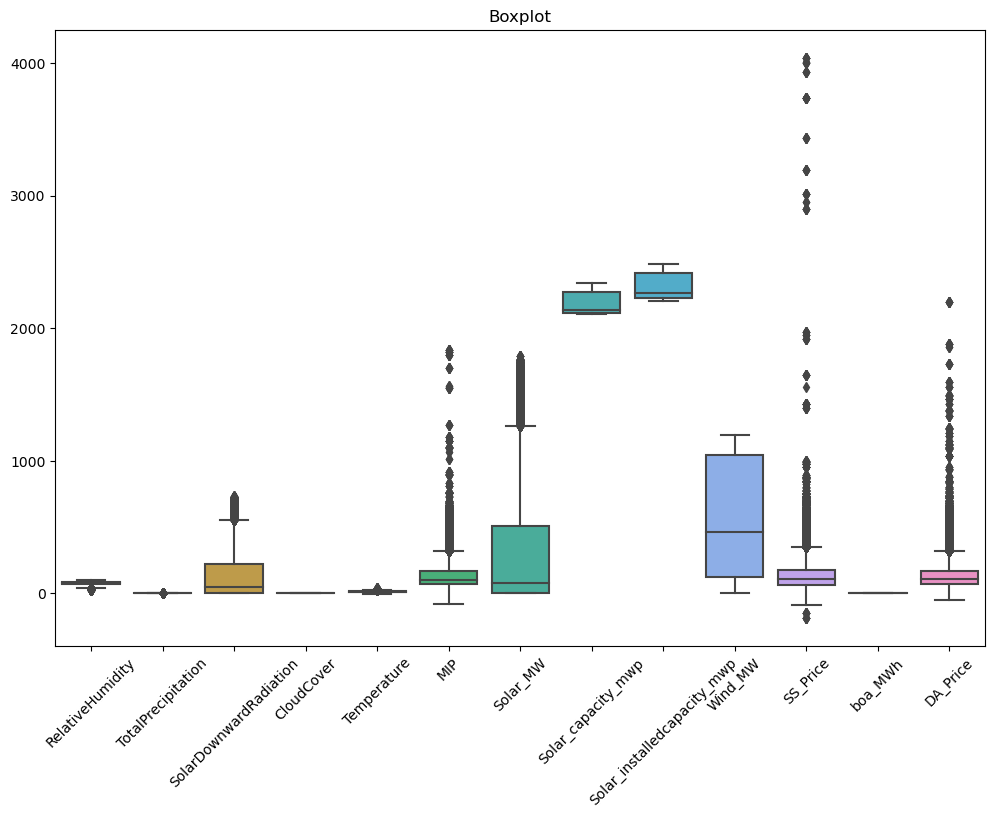

In [16]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=dataRaw.select_dtypes(include=np.number))
plt.title('Boxplot')
plt.xticks(rotation=45)

plt.show()

We can observe that there are indeed outliers. How we know it ? Because we saw that we can consider a data as an outlier if it's value is outside the mean + or - 3 times the standard deviation. And here there are visualized with the points outside the maximum or the minimum.

# Feature Engineering

In [17]:
threshold = 3
scores = np.abs(stats.zscore(dataRaw.select_dtypes(include=np.number)))
outlierRows = np.any(scores > threshold, axis=1)

In [18]:
dataCleaned = dataRaw[~outlierRows]
dataCleaned

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
5,2020-09-20 00:00:00+00:00,2020-09-20 05:00:00+00:00,93.136665,0.000000,1.560938,0.702958,14.118970,2020-09-20 05:00:00+00:00,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414947,2023-10-26 00:00:00+00:00,2023-10-27 22:00:00+00:00,95.594032,0.002232,0.009360,0.445369,8.483948,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414950,2023-10-26 18:00:00+00:00,2023-10-27 22:00:00+00:00,95.839966,0.000558,0.000540,0.474188,8.563037,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,96.149948,0.007254,0.011918,0.702725,8.493952,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,96.074356,0.008929,0.013232,0.771242,8.299957,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


We can not use feature with datetime type for our model, we will keep them by creature features as year, month, day, hour, minute and second.

In [19]:
dataCleaned = dataCleaned.copy()
dataCleaned['dtm'] = pd.to_datetime(dataCleaned['dtm'],utc=True)
dataCleaned['year'] = dataCleaned['dtm'].dt.year
dataCleaned['month'] = dataCleaned['dtm'].dt.month
dataCleaned['day'] = dataCleaned['dtm'].dt.day
dataCleaned['hour'] = dataCleaned['dtm'].dt.hour
dataCleaned['minute'] = dataCleaned['dtm'].dt.minute
dataCleaned['second'] = dataCleaned['dtm'].dt.second

timeFeatures = ['dtm','ref_datetime','valid_datetime']
DataNoTime = dataCleaned.drop(timeFeatures, axis=1).copy()



### Imputation of the missing data


There are several NaN data in the dataset as we can see below.

In [20]:
DataNoTime.isna().sum()

RelativeHumidity                 0
TotalPrecipitation               0
SolarDownwardRadiation           0
CloudCover                       1
Temperature                      0
MIP                            942
Solar_MW                       162
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                          0
SS_Price                         0
boa_MWh                          0
DA_Price                         0
year                             0
month                            0
day                              0
hour                             0
minute                           0
second                           0
dtype: int64

In [21]:
NombreNA = DataNoTime.isna().sum().sum()
row,col = DataNoTime.shape[0],DataNoTime.shape[1]
PourcentageNA = NombreNA*100/(row*col)
PourcentageNA


0.035793218205499716

The amount of missing data seems quite low (3% < 5% of the total of the data from dataset).
It may be not interesting to impute them.
We wanted to experiment an Imputer especially the KNN Imputer which will allow to associate the missing data to a group with similiar values.
And not by imputating by the mean value which will create a distorsion on the values of the dataset

In [22]:
def imputationKNN(df):
    """
    Function that imputates the NaN values.
    
    :param Dataframe df: a pandas dataset with nan values
    :returns: an imputated dataset
    """
    from sklearn.impute import KNNImputer
    dataImputed = KNNImputer(missing_values=np.nan,n_neighbors=3).fit_transform(df)
    dataImputed = pd.DataFrame(dataImputed, columns=df.columns)
    return dataImputed

In [23]:
dataImputed = imputationKNN(DataNoTime)

In [24]:
dataImputed.isna().sum()

RelativeHumidity               0
TotalPrecipitation             0
SolarDownwardRadiation         0
CloudCover                     0
Temperature                    0
MIP                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
Wind_MW                        0
SS_Price                       0
boa_MWh                        0
DA_Price                       0
year                           0
month                          0
day                            0
hour                           0
minute                         0
second                         0
dtype: int64

In [25]:
dataImputed

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,2020.0,9.0,20.0,1.0,0.0,0.0
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,2020.0,9.0,20.0,2.0,0.0,0.0
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54,2020.0,9.0,20.0,3.0,0.0,0.0
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28,2020.0,9.0,20.0,4.0,0.0,0.0
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79,2020.0,9.0,20.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,95.594032,0.002232,0.009360,0.445369,8.483948,97.16,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023.0,10.0,27.0,22.0,0.0,0.0
162479,95.839966,0.000558,0.000540,0.474188,8.563037,97.16,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023.0,10.0,27.0,22.0,0.0,0.0
162480,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023.0,10.0,27.0,23.0,0.0,0.0
162481,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023.0,10.0,27.0,23.0,0.0,0.0


## Data Observation


We will now plot the data to see their distribution.

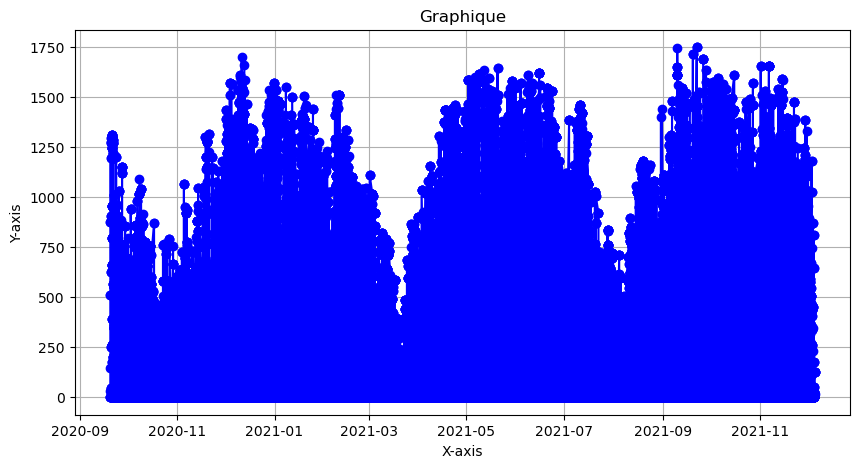

In [26]:
def plot_data2D(df, x_col, y_col, title="Graphique", x_label="X-axis", y_label="Y-axis", grid=True, line_style='-', marker_style='o', color='b'):
    plt.figure(figsize=(10, 5))
    plt.plot(df[x_col], df[y_col], linestyle=line_style, marker=marker_style, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if grid:
        plt.grid(True)
    plt.show()

dataImputed2 = pd.concat([dataImputed, dataCleaned['dtm']], axis=1)
dataImputed2 = dataImputed2.dropna(subset=['dtm'])

plot_data2D(dataImputed2, 'dtm', 'Solar_MW')


Text(0, 0.5, 'Generation [MW]')

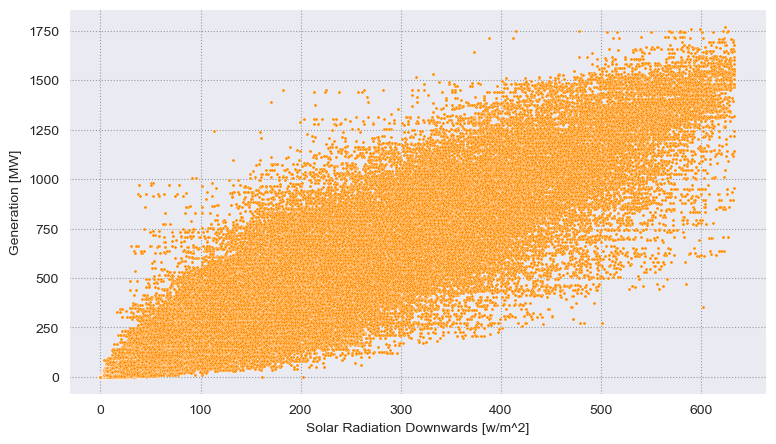

In [27]:
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=dataCleaned, x="SolarDownwardRadiation", 
                y="Solar_MW", color='darkorange',s=5)
plt.xlabel('Solar Radiation Downwards [w/m^2]')
plt.ylabel('Generation [MW]')

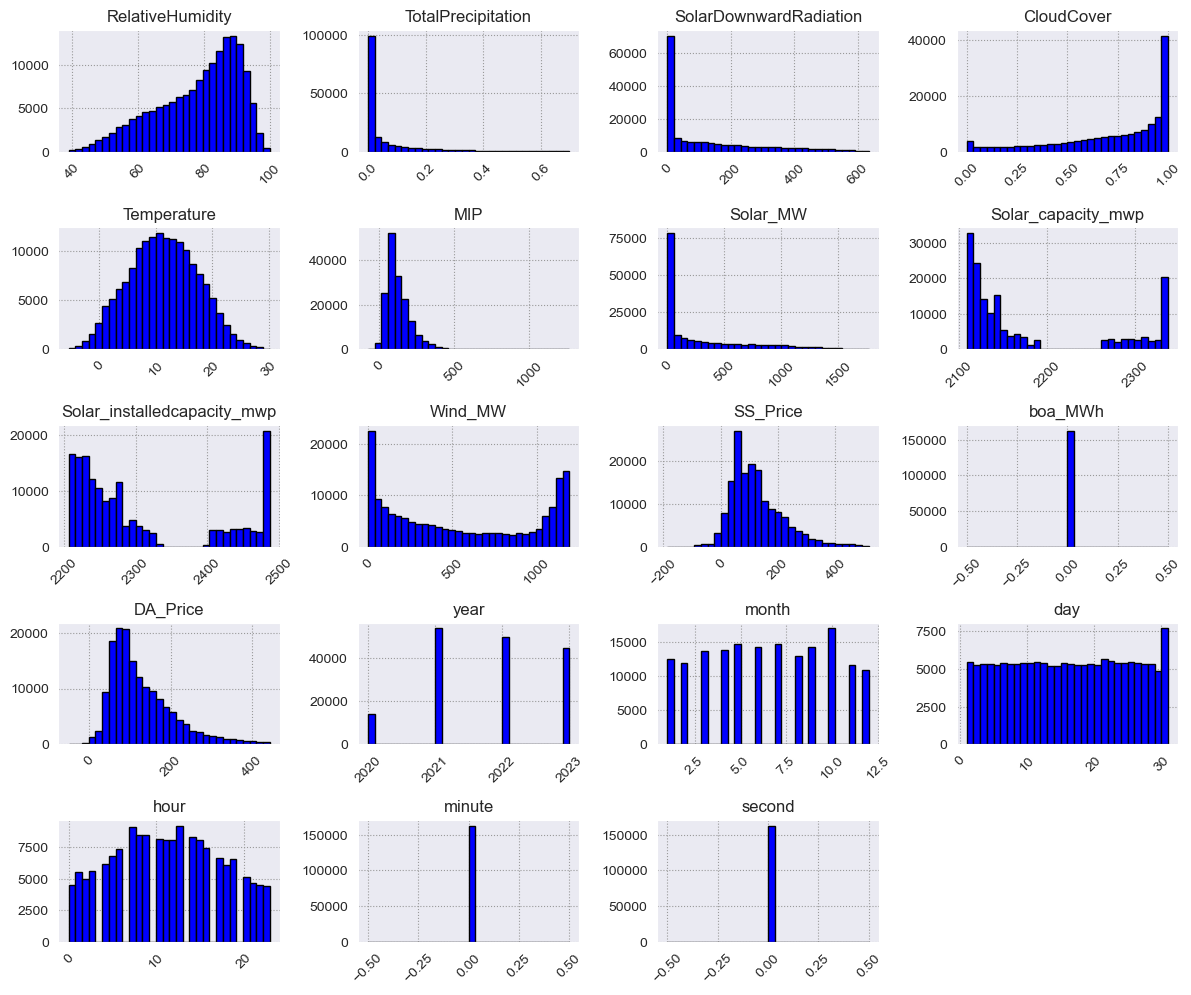

In [28]:
cols_to_plot = [col for col in dataImputed.columns]

plt.figure(figsize=(12, 10))

# we iterate for each columns
for i, col in enumerate(cols_to_plot):
    plt.subplot(5, 4, i + 1)
    plt.hist(dataImputed[col].dropna(), bins=30, color='blue', edgecolor='black')
    plt.title(col)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## Preprocessing
We can observe that the distribution of some features are left and right skewed which can be troublesome to deal with.

Left Skewed : 
- TotalPrecipitation 
- SolarDownwardRadiation
- MIP
- Solar_capacity_mwp
- SS_Price 
- DA_Price

Right Skewed : 
- RelativeHumidity
- CloudCover

In order to correct this, we will apply a logarithmic function to positive features and cube root function to other.

In [29]:
dataImputed['log_TotalPrecipitation'] = np.log(dataImputed['TotalPrecipitation'])
dataImputed['log_SolarDownwardRadiation'] = np.log(dataImputed['SolarDownwardRadiation'])
dataImputed['cube_root_MIP'] = np.cbrt(dataImputed['MIP'])
dataImputed['log_Solar_capacity_mwp'] = np.log(dataImputed['Solar_capacity_mwp'])
dataImputed['cube_root_SS_Price'] = np.cbrt(dataImputed['SS_Price'])
dataImputed['cube_root_DA_Price'] = np.cbrt(dataImputed['DA_Price'])

dataImputed['log_RelativeHumidity'] = np.log(dataImputed['RelativeHumidity'])
dataImputed['log_CloudCover'] = np.log(dataImputed['CloudCover'])
dataImputed

/Users/pol/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_TotalPrecipitation,log_SolarDownwardRadiation,cube_root_MIP,log_Solar_capacity_mwp,cube_root_SS_Price,cube_root_DA_Price,log_RelativeHumidity,log_CloudCover
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,...,0.0,0.0,-inf,-inf,3.060975,7.653727,3.632979,3.174802,4.521506,-0.705184
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,...,0.0,0.0,-inf,-inf,3.043442,7.653727,3.070550,3.174471,4.527654,-0.604385
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,...,0.0,0.0,-inf,-inf,3.054557,7.653727,3.137999,3.192561,4.539068,-0.466695
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,...,0.0,0.0,-inf,-inf,2.884499,7.653727,3.072317,3.184035,4.544210,-0.384103
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,...,0.0,0.0,-inf,0.445287,3.298561,7.653727,3.058838,3.200716,4.534068,-0.352458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,95.594032,0.002232,0.009360,0.445369,8.483948,97.16,0.0,2331.383994,2487.180474,132.522,...,0.0,0.0,-6.104793,-4.671338,4.597226,7.754217,5.052774,4.006448,4.560110,-0.808852
162479,95.839966,0.000558,0.000540,0.474188,8.563037,97.16,0.0,2331.383994,2487.180474,132.522,...,0.0,0.0,-7.491088,-7.523643,4.597226,7.754217,5.052774,4.006448,4.562680,-0.746150
162480,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,...,0.0,0.0,-4.926138,-4.429716,4.428330,7.754217,5.104469,3.885945,4.565909,-0.352790
162481,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,...,0.0,0.0,-4.718499,-4.325143,4.428330,7.754217,5.104469,3.885945,4.565122,-0.259753


We will standardize the data and exclude the infinite and nan values by 0.

In [30]:
scalerStand = StandardScaler()
numericCols = dataImputed.select_dtypes(include=np.number).columns
df = dataImputed
df = df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
df[numericCols] = scalerStand.fit_transform(df[numericCols])

In [31]:
df

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_TotalPrecipitation,log_SolarDownwardRadiation,cube_root_MIP,log_Solar_capacity_mwp,cube_root_SS_Price,cube_root_DA_Price,log_RelativeHumidity,log_CloudCover
0,1.103658,-0.546840,-0.796656,-0.825454,0.392109,-1.209842,-0.740502,-0.866757,-1.015572,0.898858,...,0.0,0.0,0.974188,-0.393916,-1.376429,-0.877829,-0.577976,-1.555478,1.014503,-0.272560
1,1.148806,-0.546840,-0.796656,-0.639244,0.412362,-1.216077,-0.740502,-0.866757,-1.015572,0.846784,...,0.0,0.0,0.974188,-0.393916,-1.390867,-0.877829,-0.921238,-1.555789,1.049568,-0.150037
2,1.233362,-0.546840,-0.796656,-0.352564,0.431207,-1.212132,-0.740502,-0.866757,-1.015572,0.985536,...,0.0,0.0,0.974188,-0.393916,-1.381713,-0.877829,-0.880073,-1.538740,1.114665,0.017328
3,1.271774,-0.546840,-0.796656,-0.160675,0.450178,-1.269393,-0.740502,-0.866757,-1.015572,1.041313,...,0.0,0.0,0.974188,-0.393916,-1.521754,-0.877829,-0.920160,-1.546776,1.143994,0.117721
4,1.196201,-0.546840,-0.786998,-0.082852,0.466190,-1.118098,-0.740502,-0.866757,-1.015572,1.013876,...,0.0,0.0,0.974188,-0.293223,-1.180779,-0.877829,-0.928386,-1.531054,1.086148,0.156185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,1.391800,-0.529469,-0.796598,-0.998357,-0.465351,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,0.0,0.0,-1.088942,-1.450245,-0.111344,1.770201,0.288555,-0.771660,1.234676,-0.398570
162479,1.411375,-0.542497,-0.796653,-0.895929,-0.452276,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,0.0,0.0,-1.557444,-2.095236,-0.111344,1.770201,0.288555,-0.771660,1.249330,-0.322355
162480,1.436049,-0.490385,-0.796582,-0.083682,-0.463697,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,0.0,0.0,-0.690613,-1.395607,-0.250428,1.770201,0.320105,-0.885232,1.267747,0.155782
162481,1.430032,-0.477357,-0.796574,0.159839,-0.495767,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,0.0,0.0,-0.620441,-1.371960,-0.250428,1.770201,0.320105,-0.885232,1.263262,0.268871


We will now create some features that are combination of others and that can appear interesting

In [32]:
df['Solar_capacity_x_month'] = df['Solar_capacity_mwp'] * df['month']
df['Solar_capacity_x_hour'] = df['Solar_capacity_mwp'] * df['hour']

In [33]:
df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df['is_spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
df['is_autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)
df['temp_squared'] = df['Temperature'] ** 2
df['radiation_x_cloudcover'] = df['SolarDownwardRadiation'] * df['CloudCover']

In [34]:
correlationMatrix = df.corr()
correlationMatrix

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_CloudCover,Solar_capacity_x_month,Solar_capacity_x_hour,is_summer,is_winter,is_spring,is_autumn,temp_squared,radiation_x_cloudcover
RelativeHumidity,1.000000,0.156499,-0.621767,0.128355,-0.467613,-0.033667,-0.613584,-0.057417,-0.063467,0.081103,...,0.995093,0.076115,-0.083089,-0.029149,NaN,NaN,NaN,NaN,-0.163491,0.040826
TotalPrecipitation,0.156499,1.000000,-0.074596,0.333134,0.065620,-0.076435,-0.055852,0.016271,0.012565,0.169430,...,0.161064,0.225488,0.002497,0.016926,NaN,NaN,NaN,NaN,-0.096305,-0.057129
SolarDownwardRadiation,-0.621767,-0.074596,1.000000,-0.082501,0.453638,-0.028148,0.936270,0.094222,0.098130,-0.178194,...,-0.618911,-0.029776,0.072287,-0.000732,NaN,NaN,NaN,NaN,0.152467,-0.221267
CloudCover,0.128355,0.333134,-0.082501,1.000000,0.115959,-0.068297,-0.067393,-0.007830,-0.011680,0.106267,...,0.129450,0.816629,-0.040905,-0.007251,NaN,NaN,NaN,NaN,-0.152294,-0.086262
Temperature,-0.467613,0.065620,0.453638,0.115959,1.000000,0.026192,0.415248,0.189758,0.203705,-0.162251,...,-0.461029,0.090885,0.090825,0.017083,NaN,NaN,NaN,NaN,0.028394,-0.092589
MIP,-0.033667,-0.076435,-0.028148,-0.068297,0.026192,1.000000,-0.037918,-0.130722,-0.085121,-0.130392,...,-0.036639,-0.058244,-0.075441,-0.004512,NaN,NaN,NaN,NaN,0.173015,0.040851
Solar_MW,-0.613584,-0.055852,0.936270,-0.067393,0.415248,-0.037918,1.000000,0.097643,0.101834,-0.130534,...,-0.609026,-0.023159,0.068566,0.003149,NaN,NaN,NaN,NaN,0.150008,-0.214875
Solar_capacity_mwp,-0.057417,0.016271,0.094222,-0.007830,0.189758,-0.130722,0.097643,1.000000,0.997465,-0.059388,...,-0.052468,-0.003509,-0.026317,0.004976,NaN,NaN,NaN,NaN,0.030873,0.001479
Solar_installedcapacity_mwp,-0.063467,0.012565,0.098130,-0.011680,0.203705,-0.085121,0.101834,0.997465,1.000000,-0.058622,...,-0.058653,-0.006831,-0.016482,0.005030,NaN,NaN,NaN,NaN,0.032269,0.003185
Wind_MW,0.081103,0.169430,-0.178194,0.106267,-0.162251,-0.130392,-0.130534,-0.059388,-0.058622,1.000000,...,0.095934,0.081919,-0.055427,-0.008997,NaN,NaN,NaN,NaN,-0.151678,-0.021986


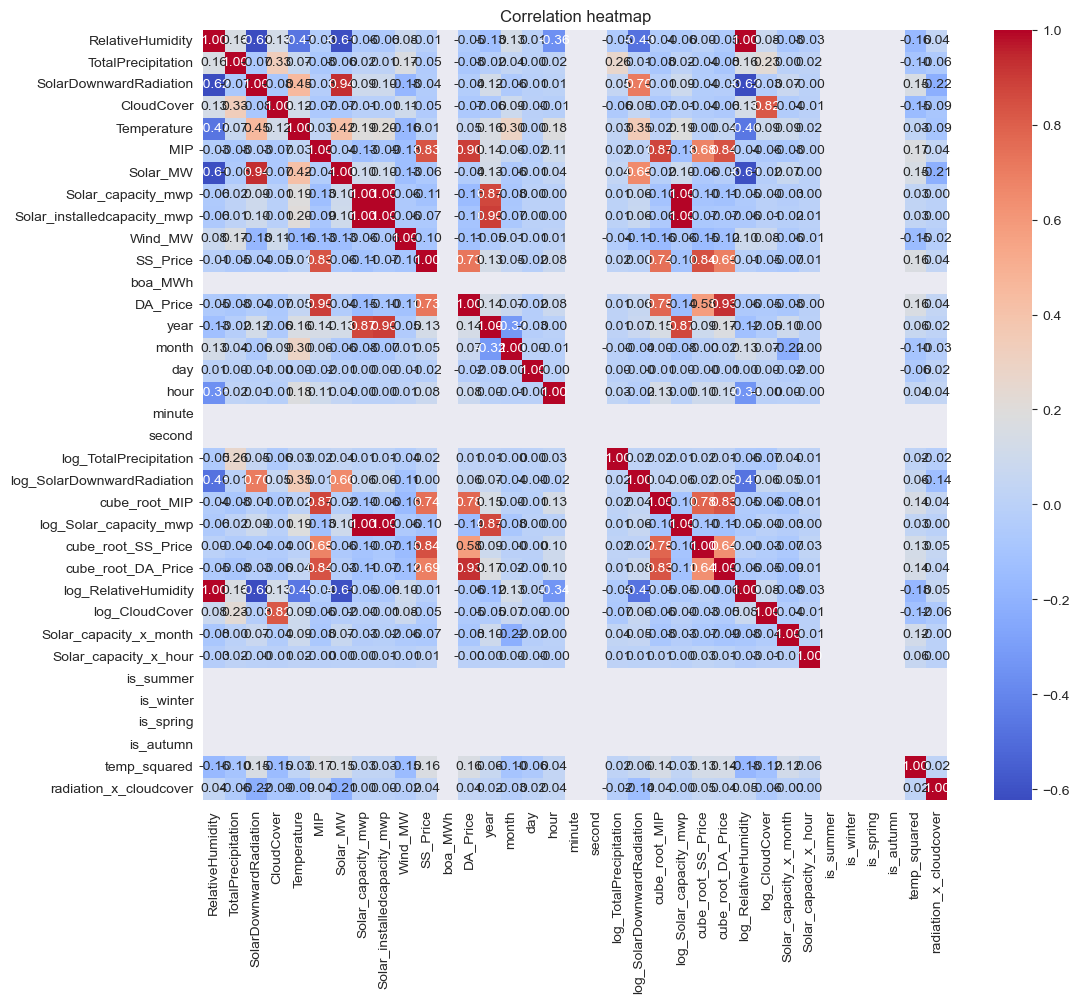

In [35]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap')
plt.show()

In [36]:
features = df.drop(['Solar_MW'], axis = 1)
target = df['Solar_MW']

We will proceed to select only the interesting features.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

selector = SelectKBest(f_regression, k=10)
selector.fit(features, target)

X_trainSelected = selector.fit_transform(X_train, y_train)
X_testSelected = selector.transform(X_test)

selectedFeaturesInter = features.columns[selector.get_support()]
print("Selected features :", selectedFeaturesInter)

selectedIndices = selector.get_support(indices=True)

selectedFeatures = features.columns[selectedIndices]

dfFinal = pd.DataFrame({'Features': selectedFeatures,
                        'Score': selector.scores_[selectedIndices],
                        'P-value': selector.pvalues_[selectedIndices]})

dfFinal.sort_values(by='P-value', inplace=True)

print(dfFinal)


Selected features : Index(['RelativeHumidity', 'SolarDownwardRadiation', 'Temperature',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'year',
       'log_SolarDownwardRadiation', 'log_RelativeHumidity', 'temp_squared',
       'radiation_x_cloudcover'],
      dtype='object')
                      Features          Score        P-value
0             RelativeHumidity   78269.390567   0.000000e+00
1       SolarDownwardRadiation  923135.761137   0.000000e+00
2                  Temperature   26998.386583   0.000000e+00
4                      Wind_MW    2260.077975   0.000000e+00
5                         year    2135.430999   0.000000e+00
6   log_SolarDownwardRadiation   97873.847026   0.000000e+00
7         log_RelativeHumidity   76397.365694   0.000000e+00
8                 temp_squared    2981.376220   0.000000e+00
9       radiation_x_cloudcover    6198.652230   0.000000e+00
3  Solar_installedcapacity_mwp    1351.222038  2.747510e-294
Index(['RelativeHumidity', 'SolarDownwardRadiation'

Evaluating the model's performance using Mean Squared Error (MSE), R² Score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):

MSE quantifies the average of the squared differences between the predicted values and the actual values, serving as a measure of prediction accuracy.

The R² Score indicates how well the model fits the data, providing an estimate of the model's ability to predict new, unseen data points.

RMSE is the square root of the MSE, offering a measure of the average magnitude of the errors in the same units as the original data.

MAPE measures the average absolute percentage error between the predicted and actual values, reflecting the accuracy as a percentage and indicating the relative size of the errors.

In [47]:
model = LinearRegression()
model.fit(X_trainSelected, y_train)

y_pred = model.predict(X_testSelected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MSE score:", mse)
print("R² Score:", r2)
print("Root Mean Squared Error (RMSE) :", rmse)
print("Mean Absolute Percentage Error (MAPE) :", mape)

lr_model = 'lr_model.pkl'

with open(lr_model, 'wb') as file:
     pickle.dump(lr_model, file)

MSE score: 0.12024026875667987
R² Score: 0.8804262418342916
Root Mean Squared Error (RMSE) : 0.34675678617249855
Mean Absolute Percentage Error (MAPE) : 0.9599385397544624


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
dtModel = DecisionTreeRegressor(random_state=23)
dtModel.fit(X_trainSelected, y_train)
dtPred = dtModel.predict(X_testSelected)
dtMse = mean_squared_error(y_test, dtPred)
dtR2 = r2_score(y_test, dtPred)
print("Decision Tree - MSE:", dtMse, "and R^2:", dtR2)

dtRmse = mean_squared_error(y_test, dtPred,squared=False)
dtMape = mean_absolute_percentage_error(y_test, dtPred)

print("Decision Tree - Root Mean Squared Error (RMSE) :", dtRmse)
print("Decision Tree - Mean Absolute Percentage Error (MAPE) :", dtMape)
dt_model = 'dt_model.pkl'

with open(dt_model, 'wb') as file:
     pickle.dump(dt_model, file)


Decision Tree - MSE: 0.07594835511334772 and R^2: 0.9244726384820038
Decision Tree - Root Mean Squared Error (RMSE) : 0.27558729127691595
Decision Tree - Mean Absolute Percentage Error (MAPE) : 0.6013383662234382


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
rfModel = RandomForestRegressor(random_state=23)
rfModel.fit(X_trainSelected, y_train)
rfPred = rfModel.predict(X_testSelected)
rfMse = mean_squared_error(y_test, rfPred)
rfR2 = r2_score(y_test, rfPred)
print("Random Forest - MSE:", rfMse, "and R^2:", rfR2)
rfMse = mean_squared_error(y_test, rfPred,squared=False)
rfMape = mean_absolute_percentage_error(y_test, rfPred)

print("Random Forest - Root Mean Squared Error (RMSE) :", rfMse)
print("Random Forest - Mean Absolute Percentage Error (MAPE) :", rfMape)

Random Forest - MSE: 0.03807511244987297 and R^2: 0.9621359438456816
Random Forest - Root Mean Squared Error (RMSE) : 0.19512845115429214
Random Forest - Mean Absolute Percentage Error (MAPE) : 0.5021146400680776


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Globally, the random forest is better even though its computation time is significantly higher. We will proceed to apply a grid search cross validation to optimize its hyper parameters.


DON'T RUN THIS CELL, WE HAVE ALREADY DONE IT AND SAVE THE RESULTED MODEL INTO A PICKLE FILE THAT WE WILL LOAD AFTER.

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split

rfModel = RandomForestRegressor(random_state=42)

paramGrid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gridSearch = GridSearchCV(estimator=rfModel, param_grid=paramGrid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gridSearch.fit(X_trainSelected, y_train)

bestParams = gridSearch.best_params_
print("Best parameters found: ", bestParams)

bestRfModel = gridSearch.best_estimator_
bestRfModel.fit(X_trainSelected, y_train)

bestRfPred = bestRfModel.predict(X_testSelected)

bestRfMse = mean_squared_error(y_test, bestRfPred)
bestRfR2 = r2_score(y_test, bestRfPred)
bestRfMse = mean_squared_error(y_test, bestRfPred, squared=False)
bestRfMape = mean_absolute_percentage_error(y_test, bestRfPred)

print("Random Forest - MSE:", bestRfMse, "and R^2:", bestRfR2)
print("Random Forest - Root Mean Squared Error (RMSE):", bestRfMse)
print("Random Forest - Mean Absolute Percentage Error (MAPE):",bestRfMape)


Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - MSE: 0.19504646864249842 and R^2: 0.961995215861859
Random Forest - Root Mean Squared Error (RMSE): 0.19504646864249842
Random Forest - Mean Absolute Percentage Error (MAPE): 0.6426331135890242


c:\Users\pphong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We decided that loading the model into a pickle will allow us to avoid the massive computing time at each run.

In [43]:
import pickle
model_filename = 'best_rf_model.pkl'
#with open(model_filename, 'wb') as file:
#    pickle.dump(bestRfModel, file)

print(f"Model saved to {model_filename}")
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Utiliser le modèle chargé pour faire des prédictions
loaded_rf_preds = loaded_model.predict(X_testSelected)

# Calculer les métriques de performance pour vérifier que le modèle a été correctement chargé
loaded_rf_mse = mean_squared_error(y_test, loaded_rf_preds)
loaded_rf_r2 = r2_score(y_test, loaded_rf_preds)
loaded_rmse = mean_squared_error(y_test, loaded_rf_preds, squared=False)
loaded_mape = mean_absolute_percentage_error(y_test, loaded_rf_preds)

print("Loaded Random Forest - MSE:", loaded_rf_mse, "and R^2:", loaded_rf_r2)
print("Loaded Root Mean Squared Error (RMSE):", loaded_rmse)
print("Loaded Mean Absolute Percentage Error (MAPE):", loaded_mape)

Model saved to best_rf_model.pkl


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded Random Forest - MSE: 0.012172533488512709 and R^2: 0.9878949407659359
Loaded Root Mean Squared Error (RMSE): 0.1103292050570143
Loaded Mean Absolute Percentage Error (MAPE): 0.2659346575614847


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Prediction

We will now clean and preprocessed the dataset for the prediction.

We first load the several files that our models haven't seen.

In [46]:
dataPD2024 = pd.read_csv("Energy_Data_20200920_20240118.csv")
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'], utc=True)
data_demand_1= xr.open_dataset("dwd_icon_eu_demand_20231027_20240108.nc")
data_demand_2 = xr.open_dataset("dwd_icon_eu_demand_20240108_20240129.nc")
data_demand = xr.merge([data_demand_1,data_demand_2], join="outer")
data_demand = data_demand.rename({'reference_time': 'ref_datetime'})
data_demand = data_demand.rename({'valid_time': 'valid_datetime'})
ds_sorted = data_demand.sortby('ref_datetime')
# Convertir le timestamp en numpy.datetime64

date_limite = np.datetime64('2024-01-18')
date_début = np.datetime64('2023-10-28')

# Sélectionnez les données jusqu'à la date limite inclusive
data_demand = ds_sorted.sel(ref_datetime=slice(date_début, date_limite ))
data_demand_features1 = data_demand["RelativeHumidity"].mean(dim="point").to_dataframe().reset_index()
data_demand_features2 = data_demand["TotalPrecipitation"].mean(dim="point").to_dataframe().reset_index()

data_demand_features = data_demand_features1.merge(data_demand_features2,how="outer",on=["ref_datetime","valid_datetime"])

# # Convertir la colonne valid_datetime en datetime si ce n'est pas déjà fait
data_demand_features["ref_datetime"]=data_demand_features["ref_datetime"].dt.tz_localize("UTC")
data_demand_features["valid_datetime"] = data_demand_features["ref_datetime"] + pd.TimedeltaIndex(data_demand_features["valid_datetime"],unit="hours")
dataNC2024_1 = xr.open_dataset("dwd_icon_eu_pes10_20240108_20240129.nc")
dataNC2024_2 = xr.open_dataset("dwd_icon_eu_pes10_20231027_20240108.nc")
dataNC2024 = xr.merge([dataNC2024_1, dataNC2024_2], join='outer')
dataNC2024 = dataNC2024.rename({'reference_time': 'ref_datetime'})
dataNC2024 = dataNC2024.rename({'valid_time': 'valid_datetime'})
ds_sorted = dataNC2024.sortby('ref_datetime')
# Convertir le timestamp en numpy.datetime64

date_limite = np.datetime64('2024-01-18')
date_début = np.datetime64('2023-10-28')

# Sélectionnez les données jusqu'à la date limite inclusive
dataNC2024 = ds_sorted.sel(ref_datetime=slice(date_début, date_limite ))
dataNC2024_features1 = dataNC2024["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dataNC2024_features2 = dataNC2024["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dataNC2024_features3 = dataNC2024["Temperature"].mean(dim="point").to_dataframe().reset_index()

dataNC2024_featuresInter = dataNC2024_features1.merge(dataNC2024_features2,how="outer",on=["ref_datetime","valid_datetime"])
dataNC2024_features = dataNC2024_featuresInter.merge(dataNC2024_features3,how="outer",on=["ref_datetime","valid_datetime"])

dataNC2024_features["ref_datetime"]=dataNC2024_features["ref_datetime"].dt.tz_localize("UTC")
dataNC2024_features["valid_datetime"] = dataNC2024_features["ref_datetime"] + pd.TimedeltaIndex(dataNC2024_features["valid_datetime"],unit="hours")
data_merged = data_demand_features.merge(dataNC2024_features,how="outer",on=["ref_datetime","valid_datetime"])
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'])

# Définir les dates de début et de fin
date_début = pd.Timestamp('2023-10-28', tz='UTC')
date_limite = pd.Timestamp('2024-01-18', tz='UTC')

# Filtrer les données pour inclure uniquement les dates entre date_debut et date_fin
dataPD2024 = dataPD2024[(dataPD2024['dtm'] >= date_début) & (dataPD2024['dtm'] <= date_limite)]
modeling_table = data_merged
modeling_table = modeling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modeling_table = modeling_table.drop(columns="ref_datetime",axis=1).reset_index()
modeling_table = data_merged.merge(dataPD2024,how="inner",left_on="valid_datetime",right_on="dtm")
modeling_table = modeling_table[modeling_table["valid_datetime"] - modeling_table["ref_datetime"] < np.timedelta64(50,"h")]

dataRaw = modeling_table
dataRaw = dataRaw[(dataRaw['boa_MWh'] >= 0) & (dataRaw['TotalPrecipitation'] >= 0) & (dataRaw['SolarDownwardRadiation'] >= 0)]
threshold = 3
scores = np.abs(stats.zscore(dataRaw.select_dtypes(include=np.number)))
outlierRows = np.any(scores > threshold, axis=1)
dataCleaned = dataRaw[~outlierRows]
dataCleaned = dataCleaned.copy()
dataCleaned['dtm'] = pd.to_datetime(dataCleaned['dtm'],utc=True)
dataCleaned['year'] = dataCleaned['dtm'].dt.year
dataCleaned['month'] = dataCleaned['dtm'].dt.month
dataCleaned['day'] = dataCleaned['dtm'].dt.day
dataCleaned['hour'] = dataCleaned['dtm'].dt.hour
dataCleaned['minute'] = dataCleaned['dtm'].dt.minute
dataCleaned['second'] = dataCleaned['dtm'].dt.second

timeFeatures = ['dtm','ref_datetime','valid_datetime']
DataNoTime = dataCleaned.drop(timeFeatures, axis=1).copy()
dataImputed = imputationKNN(DataNoTime)
dataImputed['log_TotalPrecipitation'] = np.log(dataImputed['TotalPrecipitation'])
dataImputed['cube_root_SS_Price'] = np.cbrt(dataImputed['SS_Price'])
dataImputed['cube_root_MIP'] = np.cbrt(dataImputed['MIP'])
dataImputed['cube_root_DA_Price'] = np.cbrt(dataImputed['DA_Price'])
dataImputed['log_SolarDownwardRadiation'] = np.log(dataImputed['SolarDownwardRadiation'])
dataImputed['log_Solar_capacity_mwp'] = np.log(dataImputed['Solar_capacity_mwp'])
dataImputed['log_RelativeHumidity'] = np.log(dataImputed['RelativeHumidity'])
dataImputed['temp_squared'] = df['Temperature'] ** 2
dataImputed['radiation_x_cloudcover'] = df['SolarDownwardRadiation'] * df['CloudCover']

scalerStand = StandardScaler()
numeric_cols = dataImputed.select_dtypes(include=np.number).columns
df = dataImputed
df = df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
df[numeric_cols] = scalerStand.fit_transform(df[numeric_cols])
df['Solar_capacity_x_month'] = df['Solar_capacity_mwp'] * df['month']
df['Solar_capacity_x_hour'] = df['Solar_capacity_mwp'] * df['hour']
df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df['is_spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
df['is_autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)

correlationMatrix = df.corr()

/Users/pol/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
features = df.drop(['Solar_MW'], axis = 1)
y_test = df['Solar_MW']

In [52]:
col = ['RelativeHumidity', 'SolarDownwardRadiation', 'Temperature',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'year',
       'log_SolarDownwardRadiation', 'log_RelativeHumidity', 'temp_squared',
       'radiation_x_cloudcover']
features = features[col].copy()

In [55]:
features
model_filename2 = 'dataFinal.pkl'
with open(model_filename2, 'wb') as file:
   pickle.dump(features, file)


In [56]:
model_filename = 'best_rf_model.pkl'

with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

loaded_rf_preds = loaded_model.predict(features)

loaded_rf_mse = mean_squared_error(y_test, loaded_rf_preds)
loaded_rf_r2 = r2_score(y_test, loaded_rf_preds)
loaded_rmse = mean_squared_error(y_test, loaded_rf_preds, squared=False)
loaded_mape = mean_absolute_percentage_error(y_test, loaded_rf_preds)

print("Loaded Random Forest - MSE:", loaded_rf_mse, "and R^2:", loaded_rf_r2)
print("Loaded Root Mean Squared Error (RMSE):", loaded_rmse)
print("Loaded Mean Absolute Percentage Error (MAPE):", loaded_mape)

/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warni

Loaded Random Forest - MSE: 0.4650748562739608 and R^2: 0.534925143726039
Loaded Root Mean Squared Error (RMSE): 0.6819639699236029
Loaded Mean Absolute Percentage Error (MAPE): 3.1997755749337595


/Users/pol/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Dashboard